# k近邻
$d = \quad \sqrt[p]{|x_1 - x_2|^{p}}$
* p = 1：曼哈顿距离
* p = 2：欧氏距离
* p = 无限大：闵氏距离

In [1]:
import math

In [2]:
# 输入两个样本a和b，输出它们的Lp距离
def distance(a,b,p = 2): # 默认是欧氏距离
    if p == float('inf'):
        maxi = float('-inf') # 一个足够小的数
        for i in range(len(a)):
            maxi = max(maxi,abs(a[i] - b[i])) # 找出所有维度中最大的差值
        return maxi
    else:
        sum = 0
        for i in range(len(a)):
            sum += math.pow(abs(a[i] - b[i]),p)
        return math.pow(sum,1.0/p)

## 计算范数

In [3]:
x1 = [1,1]
x2 = [5,1]
x3 = [4,4]
print("distance(x1,x2,p=1) = {}\n\
distance(x1,x2,p=2) = {}\n\
distance(x1,x2,p=3) = {}\n\
distance(x1,x2,p=4) = {}\n\
distance(x1,x2,p=float('inf')) = {}\n\
-------------------------------\n\
distance(x1,x3,p=1) = {}\n\
distance(x1,x3,p=2) = {}\n\
distance(x1,x3,p=3) = {}\n\
distance(x1,x3,p=4) = {}\n\
distance(x1,x3,p=float('inf')) = {}".format(distance(x1,x2,p=1),\
                                            distance(x1,x2,p=2),\
                                            distance(x1,x2,p=3), \
                                            distance(x1,x2,p=4),\
                                            distance(x1,x2,p=float('inf')),\
                                 distance(x1,x3,p=1),\
                                 distance(x1,x3,p=2),\
                                 distance(x1,x3,p=3),\
                                 distance(x1,x3,p=4),\
                                 distance(x1,x3,p=float('inf'))
                                 
                                           ))

distance(x1,x2,p=1) = 4.0
distance(x1,x2,p=2) = 4.0
distance(x1,x2,p=3) = 3.9999999999999996
distance(x1,x2,p=4) = 4.0
distance(x1,x2,p=float('inf')) = 4
-------------------------------
distance(x1,x3,p=1) = 6.0
distance(x1,x3,p=2) = 4.242640687119285
distance(x1,x3,p=3) = 3.7797631496846193
distance(x1,x3,p=4) = 3.5676213450081633
distance(x1,x3,p=float('inf')) = 3


In [4]:
## 使用numpy.linalg.norm函数计算范数

In [5]:
import numpy as np

In [6]:
print(np.linalg.norm(np.array(x1) - np.array(x2), ord = 1))
print(np.linalg.norm(np.array(x1) - np.array(x2), ord = 2))
print(np.linalg.norm(np.array(x1) - np.array(x2), ord = 3))
print(np.linalg.norm(np.array(x1) - np.array(x2), ord = 4))
print(np.linalg.norm(np.array(x1) - np.array(x2), ord = float('inf')))
print('--------------------')
print(np.linalg.norm(np.array(x1) - np.array(x3), ord = 1))
print(np.linalg.norm(np.array(x1) - np.array(x3), ord = 2))
print(np.linalg.norm(np.array(x1) - np.array(x3), ord = 3))
print(np.linalg.norm(np.array(x1) - np.array(x3), ord = 4))
print(np.linalg.norm(np.array(x1) - np.array(x3), ord = float('inf')))

4.0
4.0
3.9999999999999996
4.0
4.0
--------------------
6.0
4.242640687119285
3.7797631496846193
3.5676213450081633
3.0


## 载入鸢尾花数据集

In [7]:
import pandas as pd
from sklearn.datasets import load_iris
import matplotlib.pyplot as plt
%matplotlib inline

np.random.seed()

In [8]:
iris = load_iris()
iris_df = pd.DataFrame(iris.data,columns = iris.feature_names)
iris_df['label'] = iris.target

In [9]:
# 取前100行的第0列，第1列，最后1列数据
data = np.array(iris_df.iloc[:100,[0,1,-1]])
X,Y = data[:,:-1], data[:,-1]
print(data.shape)

(100, 3)


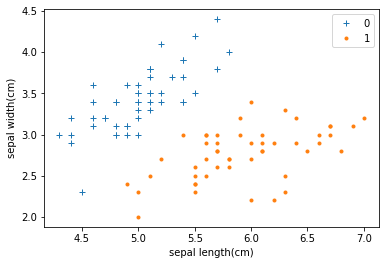

In [10]:
# 绘制训练数据集
plt.plot(data[:50,0],data[:50,1],'+',label='0')
plt.plot(data[50:100,0],data[50:100,1],'.',label='1')
plt.xlabel('sepal length(cm)')
plt.ylabel('sepal width(cm)')
plt.legend()

In [11]:
# 保存数据集
np.savez_compressed('iris.npz',data=data,X=X,Y=Y)

In [12]:
# 测试刚才保存的数据集
iris_npz = np.load('iris.npz')
data = iris_npz['data']
X = iris_npz['X']
Y = iris_npz['Y']

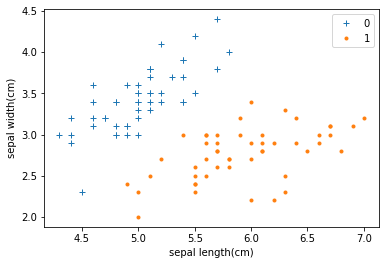

In [13]:
plt.plot(data[:50,0],data[:50,1],'+',label='0')
plt.plot(data[50:100,0],data[50:100,1],'.',label='1')
plt.xlabel('sepal length(cm)')
plt.ylabel('sepal width(cm)')
plt.legend()

## kd数的生成

In [14]:
class KDNode: # KD树节点
    def __init__(self,sample,feature_index,left,right):
        self.sample = sample # 当前节点的值
        self.feature_index = feature_index # 维度下标（l）
        self.left = left # 左子树
        self.right = right # 右子树

In [15]:
class KDTree:
    def __init__(self,dataset):
        self.n_features = dataset.shape[1] - 1 # 设定维度，最后一列是标签
        self.root = self.Build(dataset,0)
    # 从第 feature_index维度开始，在数据集dataset上构建 KD树
    def Build(self,dataset,feature_index):
        if len(dataset) == 0:
            return None
        dataset = sorted(dataset,key=lambda x:x[feature_index]) # 按照维度排序
        split_pos = len(dataset)//2 # 找到中位数
        
        # 生成一个节点，在 feature_index 维度上，它处于数据集中间位置
        # 小于和大于 dataset[split_pos] 的数据分别构建当前节点的左右子树，子树维度为: feature + 1
        return KDNode(dataset[split_pos], feature_index,\
                    self.Build(dataset[:split_pos], (feature_index + 1)\
                    % self.n_features),\
                    self.Build(dataset[split_pos+1:], (feature_index + 1)\
                    % self.n_features))
    
    # 参数：KDTree 树节点 KDNode、源数据点、KDTree 中的最近数据点、最近距离
    # 返回：KDTree 中的最近数据点、最近距离
    # kdnode最开始表示根节点root，source是需要分类的节点，target是想要找到的离source最近的节点
    def _FindNearest(self,kdnode,source,target,mindist): 
        # 叶子节点的左右节点都为None
        if kdnode == None: # 无节点可以访问
            return None, float('inf') # 数据点，距离
        
        # 当前节点
        pivot = kdnode.sample
        # 在 feature_index 维度上，当前源数据点的值小于等于当前节点的值
        # 每一个节点的feature_index值在构建kd树时就已决定好
        if source[kdnode.feature_index] <= pivot[kdnode.feature_index]: # 左子树
            forward = kdnode.left
            backward = kdnode.right
        else: #右子树
            forward = kdnode.right
            backward = kdnode.left
            
        # 往子树递归访问
        # 将节点forward作为根节点
        forward_result = self._FindNearest(forward,source,target,mindist) # [节点，最小距离]
        if forward_result[1] < mindist: # 发现目前最近距离
            target = forward_result[0]
            mindist = forward_result[1]
            
        # -1.去除标签数据
        to_pivot = np.linalg.norm(source[:-1] - pivot[:-1],ord = 2) # linalg=linear（线性）+algebra（代数），norm表示范数。
        # x_norm=np.linalg.norm(x, ord=None, axis=None, keepdims=False)
        # x是一个矩阵
        # axis：处理类型，None表示矩阵范数，1表示按行向量处理，0表示按列向量处理
        # keepding：是否保持矩阵的二维特性
        
        # pivot离source更远，不可能找到更近的点，不访问另一分支backward，直接返回
        if mindist < to_pivot:
            return target,mindist
        
        # 发现更近的数据点，更新数据
        target = pivot
        mindist = to_pivot
        backward_result = self._FindNearest(backward, source, target, mindist)
        # 继续在另一分支backward上搜索，有可能找到更近的点
        if backward_result[1] < mindist: # 发现目前最近距离          
            target = backward_result[0]
            mindist = backward_result[1] 
        return target,mindist
        
    def Nearest(self,source):
        result = self._FindNearest(self.root,source,None,float('inf'))
        return result[0] # 返回KDTree中最近数据点
            
    
    

## 测试

In [16]:
# 最后一列是标签
example_data = np.array([[2,3,0],[5,4,0],[9,6,0],[4,7,1],[8,1,1],[7,2,1]])
example_kdtree = KDTree(example_data)

In [17]:
# 按先根遍历打印KDTree
def print_kdtree(root):
    if root == None:
        return
    print(root.sample)
    print_kdtree(root.left)
    print_kdtree(root.right)
print_kdtree(example_kdtree.root)

[7 2 1]
[5 4 0]
[2 3 0]
[4 7 1]
[9 6 0]
[8 1 1]


In [18]:
# 在KDTree中搜索
source = np.array([2,16,0])
print('Nearest:',example_kdtree.Nearest(source))

Nearest: [4 7 1]


## 按穷举法搜索

In [19]:
print('Nearest:',example_data[np.argmin([np.linalg.norm(item[:-1]-source[:-1],ord=2) for item in example_data])]) 
# np.argmin:给出水平方向最小值的下标
# 计算source和item之间的L2距离，找出最小的一个
# "[for item in ...]"这种语句叫列表生成器

Nearest: [4 7 1]


## 测试随机生成的数据

In [26]:
import time
from random import random
# No module named 'time.clock'; 'time' is not a package
# time模块中的clock()已被移除，可以用time.perf_counter()代替

In [25]:
K = 6 # 维度 5，最后 1 维，假定为标签
N = 400000
random_data = np.array([[random() for k in range(K)] for n in range(N)])
t0 = time.perf_counter()
random_kdtree = KDTree(random_data)
t1 = time.perf_counter()
print ("KDTree building time: ", t1-t0, "s")
source = [random() for k in range(K)]
t0 = time.perf_counter()
print('Nearst:', random_kdtree.Nearest(source)) # 在 KDTree 树中搜索
t1 = time.perf_counter()
print ("KDTree searching time: ", t1-t0, "s")
t0 = time.perf_counter()
print('Nearst:', random_data[np.argmin([np.linalg.norm(item[:-1]-source[:-1],
ord = 2) for item in random_data])]) # 按穷举法搜索
t1 = time.perf_counter()
print ("One-by-one searching time: ", t1-t0, "s")

KDTree building time:  10.126338299999986 s
Nearst: [0.04821266 0.05123773 0.33358951 0.51721827 0.17016226 0.90553406]
KDTree searching time:  0.0014681999999766049 s
Nearst: [0.04821266 0.05123773 0.33358951 0.51721827 0.17016226 0.90553406]
One-by-one searching time:  6.907106999999996 s


## 测试鸢尾花数据集

In [27]:
iris_kdtree = KDTree(data)
source = np.array([5,4,0])
print('Nearest:',iris_kdtree.Nearest(source)) # 在KDTree中搜索
print('Nearst:', data[np.argmin([np.linalg.norm(item[:-1]-source[:-1],
ord = 2) for item in data])]) # 按穷举法搜索

Nearest: [5.1 3.8 0. ]
Nearst: [5.1 3.8 0. ]


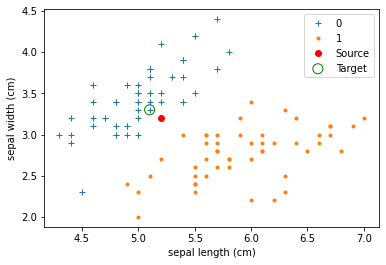

In [31]:
source = np.array([5.2, 3.2, 0])
target = iris_kdtree.Nearest(source)
plt.plot(data[:50, 0], data[:50, 1], '+', label='0')
plt.plot(data[50:100, 0], data[50:100, 1], '.', label='1')
plt.plot(source[0], source[1], 'ro', label='Source')
plt.scatter(target[0], target[1],color=[], marker = 'o', edgecolors = 'g', s = 100, label='Target')
plt.xlabel('sepal length (cm)')
plt.ylabel('sepal width (cm)')
plt.legend()

## sklearn 的 kNN 分类器
*sklearn.neighbors.KNeighborsClassifier - n_neighbors: 临近点个数 - p: 距离度量 - algorithm:
实现算法，可选 {’auto’, ’ball_tree’, ’kd_tree’, ’brute’} - weights: 确定近邻的权重*

In [32]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split

In [33]:
# 鸢尾花数据集的 80% 用作训练数据，20% 用作测试数据
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2)

In [34]:
clf = KNeighborsClassifier()
clf.fit(X_train, Y_train)

KNeighborsClassifier()

In [35]:
clf.score(X_test, Y_test)

1.0